# Solutions for Exercises and Replication of the Plots from the Chapter 2

## Exercise 2.1. <br>
Suppose there are two actions, $A_1$ and $A_2$, $Q_t(A_1) > Q_t(A_2)$.
Then $$\mathbb{P}(A_t = A_1) = (1 - \epsilon) + \epsilon*0.5 = 0.5 + 0.5*0.5 = 0.75$$
The second summand is due to the uniform distribution over actions (i.e., every action is equally likely to be selected at the exploratory step).

## Exercise 2.2. <br>
Suppose ties are broken at random. Then the first action is randomly chosen, and it is action 1. On the second time step, exploration step definitely occurred because $Q_1(1) > Q_1(a) \ \forall a \neq 1$, so greedy step would have picked action 1. On the third step, exploration step could have occurred, but so could have exploitation step. The fourth step could have been either explorative or exploitative. The fifth step was definitely explorative because $Q_5(2) > Q_5(a) \ \forall a \neq 2$, so greedy step would have picked action 2. 

In [93]:
#import all libraries that the code will use
import random as rd
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [94]:
#defines the bandit class - this class will be utilized everywhere in the chapter
#except for the gradient_bandit algorithm for which I wrote a child class

class Bandit:
    
    #constructor for the class; takes the number of bandit arms, mean and variance
    #of the Normal distribution as inputs
    def __init__(self, k = 10, mean = 0, variance = 1):
        self.k = k 
        #set the q values
        self.q = [rd.gauss(mean, variance) for i in range(k)]
        
    #a function to generate a one full run of a Bandit for epsilon-greedy algorithm
    #incorporates both constant alpha and average update
    
    def run(self, runs = 1000, epsilon = 0.1, initial = 0, 
            type_al = 'average', alpha = 0.1, variance = 1, 
            mean_nonstat = 0, variance_nonstat = 0.01,
            type_problem = 'stationary'):
        #this stores whether optimal action was visited on the n's run
        optimal_actions_pct = [0]*runs
        #this stores rewards for each step
        average_rewards = [0]*runs
        #this stores average rewards for each action: Q(a)/n where Q(a) is the sum of rewards
        #for action a, and n is the number of times action a was used (visited)
        action_rewards = [initial]*self.k
        #this we need to store the number of times each action was used
        action_counts = [0]*self.k
        #determine optimum in case of the stationary problem
        if type_problem == 'stationary':
            optimal = self.q.index(max(self.q))
        #run the simulation
        for run in range(runs):
            #update self.q and optimal action for the non-staionary problem
            if type_problem == 'nonstationary':
                self.q = [i + rd.gauss(mean_nonstat, variance_nonstat) for i in self.q]
                optimal = self.q.index(max(self.q))
            eps = rd.random() #draw epsilon from the uniform distribution
            if eps<epsilon:
                action = rd.choice(range(self.k)) #exploration step
            else:
                action = action_rewards.index(max(action_rewards)) #exploitation step
            optimal_actions_pct[run] = (action==optimal) 
            reward = rd.gauss(self.q[action], variance)
            if type_al == 'average':
                action_counts[action] += 1
                action_rewards[action] = (action_rewards[action]*(action_counts[action] - 1) 
                                         + reward)/action_counts[action]
            else:
                action_rewards[action] = action_rewards[action] + alpha*(reward - action_rewards[action])
            average_rewards[run] = reward
        return(optimal_actions_pct, average_rewards)
    
    #ucb algorithm
    
    def maximizer(self, rewards, counts, c, t):
        max_val = float('-inf')
        for x in range(len(rewards)):
            if counts[x] == 0:
                return x
            if max_val <= rewards[x] + c*(math.log(t)/counts[x])**0.5:
                max_val = rewards[x] + c*(math.log(t)/counts[x])**0.5
                action = x
        return action
    
    def run_ucb(self, runs = 1000, c = 2, initial = 0, type_al = 'average', 
                alpha = 0.1, variance = 1, mean_nonstat = 0, variance_nonstat = 0.01,
                type_problem = 'stationary'):
        #this stores whether optimal action was visited on the n's run
        optimal_actions_pct = [0]*runs
        #this stores rewards for each step
        average_rewards = [0]*runs
        #this stores average rewards for each action: Q(a)/n where Q(a) is the sum of rewards
        #for action a, and n is the number of times action a was used (visited)
        action_rewards = [initial]*self.k
        #this we need to store the number of times each action was used
        action_counts = [0]*self.k
        if type_problem == 'stationary':
            optimal = self.q.index(max(self.q))
        #run the simulation
        for run in range(runs):
            if type_problem == 'nonstationary':
                self.q = [i + rd.gauss(mean_nonstat, variance_nonstat) for i in self.q]
                optimal = self.q.index(max(self.q))
            action = self.maximizer(action_rewards, action_counts, c, run) 
            optimal_actions_pct[run] = (action==optimal) 
            reward = rd.gauss(self.q[action], variance)
            if type_al == 'average':
                action_counts[action] += 1
                action_rewards[action] = (action_rewards[action]*(action_counts[action] - 1) 
                                         + reward)/action_counts[action]
            else:
                action_rewards[action] = action_rewards[action] + alpha*(reward - action_rewards[action])
            average_rewards[run] = reward
        return(optimal_actions_pct, average_rewards)

In [95]:
epsilon_01_avr = [0]*1000
epsilon_001_avr = [0]*1000
epsilon_greedy_avr = [0]*1000

epsilon_01_opt = [0]*1000
epsilon_001_opt = [0]*1000
epsilon_greedy_opt = [0]*1000

for x in range(2000):
    new_bandit = Bandit()
    #run the experiment
    output_01 = new_bandit.run()
    output_001 = new_bandit.run(epsilon = 0.01)
    output_greedy = new_bandit.run(epsilon = 0)
    #store data for plotting
    for y in range(1000):
        epsilon_01_avr[y] += output_01[1][y]/2000
        epsilon_001_avr[y] += output_001[1][y]/2000
        epsilon_greedy_avr[y] += output_greedy[1][y]/2000

        epsilon_01_opt[y] += output_01[0][y]/2000
        epsilon_001_opt[y] += output_001[0][y]/2000
        epsilon_greedy_opt[y] += output_greedy[0][y]/2000

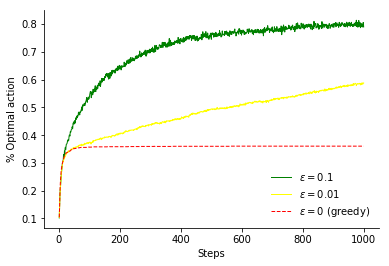

In [96]:
#Figure 2.2
#this plot illustrates how often the optimal state is visited as the number of steps grows
%matplotlib inline
rewards_data = pd.DataFrame({'x': range(1, 1001), 'e_01': epsilon_01_opt, 
                             'e_001': epsilon_001_opt, 'greedy': epsilon_greedy_opt})
fig = plt.subplot()
fig.plot( 'x', 'e_01', data=rewards_data, marker='', color='green', linewidth=1)
fig.plot( 'x', 'e_001', data=rewards_data, marker='', color='yellow', linewidth=1)
fig.plot( 'x', 'greedy', data=rewards_data, marker='', color='red', linestyle='dashed', linewidth=1)
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend(['$\epsilon = 0.1$', '$\epsilon = 0.01$', '$\epsilon = 0$ (greedy)'], frameon=False)
plt.show()

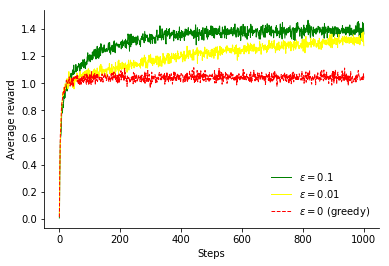

In [97]:
#Figure 2.2
#this plot illustrates the average rewards
%matplotlib inline
rewards_data = pd.DataFrame({'x': range(1, 1001), 'e_01': epsilon_01_avr, 
                             'e_001': epsilon_001_avr, 'greedy': epsilon_greedy_avr})
fig = plt.subplot()
fig.plot( 'x', 'e_01', data=rewards_data, marker='', color='green', linewidth=1)
fig.plot( 'x', 'e_001', data=rewards_data, marker='', color='yellow', linewidth=1)
fig.plot( 'x', 'greedy', data=rewards_data, marker='', color='red', linestyle='dashed', linewidth=1)
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend(['$\epsilon = 0.1$', '$\epsilon = 0.01$', '$\epsilon = 0$ (greedy)'], frameon=False)
plt.show()

What is the theory behind $\epsilon$-greedy bandit model? <br>
Define a random variable $Q_t(a)$ to be the sum of rewards for action $a$ divided by the number of times this action was visited. Rewards are, in turn, independent and identically distributed (i.i.d.) since whenever action $a$ is visited reward is drawn from a Gaussian distribution with $\mu = q^*(a)$ and $\sigma^2 = 1$. To utilize the strong law of large numbers (SLLN), we only need the algorithm to visit every $a$ infinite number of times, and $\epsilon$-greedy exploration steps guarantee that. Therefore, since each $a \in A$ is visited infinitely many times, by SLLN we have $Q(a) \to q^*(a)$ almost surely. <br>
Asymptotic consistency of $\epsilon$-greedy algorithm is a nice property, but it says nothing about the actual speed of convergence. Intuitively, when action space is large and $\epsilon$ is small, algorithm may take a very long time to converge. 

## Exercise 2.3. <br>
Let's write the expected value of reward: $$\mathbb{E}[R] = \epsilon[\sum_{j = 1}^{K}\frac{1}{K}q^*(a_j)] + (1 - \epsilon)q^*(a_i)$$ where $a_i$ is the best action available, and $K$ is the total number of actions. Now, $q^*(a_i) \geq \sum_{j = 1}^{K}\frac{1}{K}q^*(a_j)$, implying that in the long run algorithms with smaller exploration steps will perform better or at least not worse. The actual improvement can be expressed as follows. Suppose $\epsilon_1 \geq \epsilon_2$. Then $\mathbb{E}_{\epsilon_2}[R] - \mathbb{E}_{\epsilon_1}[R] = (\epsilon_2 - \epsilon_1)[(\sum_{j = 1}^{K}\frac{1}{K}q^*(a_j)] + (\epsilon_1 - \epsilon_2)q^*(a_i)$.

## Proof of the weighted average on page 25 <br>
We need to prove that $(1 - \alpha)^n + \sum_{i=1}^{n}\alpha*(1-\alpha)^{n-i} = 1$. Consider the case $n=1$. Then we have $(1 - \alpha) + \alpha = 1$, establishing the baseline case for induction. Suppose statement holds for $n$. Then $(1 - \alpha)^{n+1} + \sum_{i=1}^{n}\alpha*(1-\alpha)^{n+1-i} = 1 - \alpha \implies (1 - \alpha)^{n+1} + \sum_{i=1}^{n+1}\alpha*(1-\alpha)^{n+1-i} = 1 - \alpha + \alpha*(1-\alpha)^{n+1-n-1} = 1$

## Convergence of $\epsilon$-greedy algorithm for non-stationary rewards with $\alpha = 1/n$. <br>
For non-stationary problem, simple SLLN does not apply since rewards for actions are no longer i.i.d. Nonetheless, rewards for actions are still __independent__, so one can apply a version of SLLN referred as Kolmogorov SLLN. This version requires that each reward for a specific action is drawn from a distribution with finite second moment, and $\sum_{k=1}^{\infty}\frac{1}{k^2}Var[X_k] < \infty$. Not all distributions, of course, will satisfy these conditions, but the Normal distribution does. Finiteness of the second moment follows from standard properties of the Normal distribution. To prove the second requirement, denote $\theta = \max_{k} (Var[X_k]) < \infty$ (by the finiteness of variance of the Normal distribution). We have $\sum_{k=1}^{\infty}\frac{1}{k^2}Var[X_k] \leq \theta*\sum_{i=k}^{\infty}\frac{1}{k^2} = \theta*\frac{\pi^2}{6} < \infty$. Regarding the general applicability of these conditions, it suffices to say that most distributions of practical importance satisfy them. Robbins-Monro conditions (see page 26) are more general and allow for other sequences that lead to asymptotically consistent estimates of action values. One can check that $1/n$ sequence indeed satisfies Robbins-Monro conditions. 

## Exercise 2.5 <br>
Experiments below illustrate that asympotically consistent algorithms can demonstrate inferior performance in practice, at least when the problem is non-stationary. Selection of $\alpha$, therefore, should be informed by both theoretical (Robbins-Monro conditions) and practical considerations. 

In [98]:
#run the simulation
n_avr = [0]*10000
constant_avr = [0]*10000

n_opt = [0]*10000
constant_opt = [0]*10000

#1000 simulation of initial values - reduces computational time
for x in range(1000):
    all_val = rd.gauss(0,1)
    #per assignment, set all initial action-values to a constant
    new_bandit = Bandit(mean = all_val, variance = 0)
    #run simulation
    output_n = new_bandit.run(runs = 10000, type_problem = 'nonstationary')
    new_bandit = Bandit(mean = all_val, variance = 0)    
    output_constant = new_bandit.run(runs = 10000, type_al = 'alpha', type_problem = 'nonstationary')
    #store data for plotting 
    for y in range(10000):
        n_avr[y] += output_n[1][y]/1000
        constant_avr[y] += output_constant[1][y]/1000
        n_opt[y] += output_n[0][y]/1000
        constant_opt[y] += output_constant[0][y]/1000
    print(x, end = " ")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

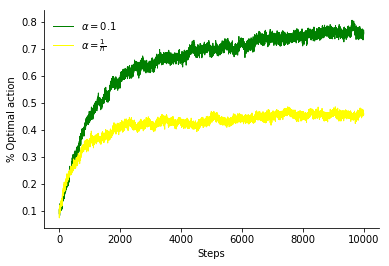

In [99]:
#generate plots
#this plot illustrates how often the optimal state is visited as the number of iterations increases
%matplotlib inline
rewards_data = pd.DataFrame({'x': range(1, 10001), 'alpha': constant_opt, 
                             'n': n_opt})
fig = plt.subplot()
fig.plot( 'x', 'alpha', data=rewards_data, marker='', color='green', linewidth=1)
fig.plot( 'x', 'n', data=rewards_data, marker='', color='yellow', linewidth=1)
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend([r'$\alpha = 0.1$', r'$\alpha = \frac{1}{n}$'], frameon=False)
plt.show()

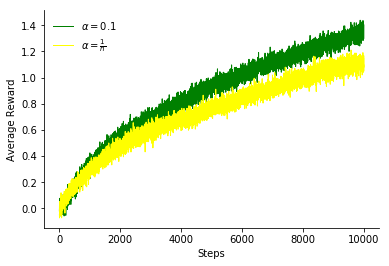

In [100]:
#generate plots
#this plot illustrates the average rewards
%matplotlib inline
rewards_data = pd.DataFrame({'x': range(1, 10001), 'alpha': constant_avr, 
                             'n': n_avr})
fig = plt.subplot()
fig.plot( 'x', 'alpha', data=rewards_data, marker='', color='green', linewidth=1)
fig.plot( 'x', 'n', data=rewards_data, marker='', color='yellow', linewidth=1)
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.legend([r'$\alpha = 0.1$', r'$\alpha = \frac{1}{n}$'], frameon=False)
plt.show()

In [101]:
#replicating figure 2.3 from the book
epsilon = [0]*1000
greedy = [0]*1000

for x in range(2000):
    new_bandit = Bandit()
    output_epsilon = new_bandit.run(type_al = "alpha")
    output_greedy = new_bandit.run(epsilon = 0, initial = 5, type_al = "alpha")
    for y in range(1000):
        epsilon[y] += output_epsilon[0][y]/2000
        greedy[y] += output_greedy[0][y]/2000

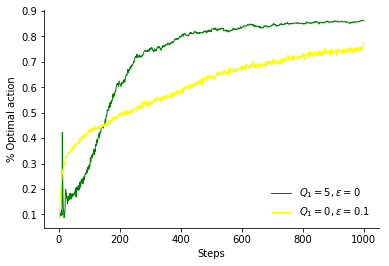

In [102]:
#replicating figure 2.3
%matplotlib inline
rewards_data = pd.DataFrame({'x': range(1, 1001), 'epsilon': epsilon, 
                             'greedy': greedy})
fig = plt.subplot()
fig.plot( 'x', 'greedy', data=rewards_data, marker='', color='green', linewidth=1)
fig.plot( 'x', 'epsilon', data=rewards_data, marker='', color='yellow', linewidth=1)
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend([r'$Q_1 = 5, \epsilon = 0$', r'$Q_1 = 0, \epsilon = 0.1$'], frameon=False)
plt.show()

## Exercise 2.4 <br>
$Q_{n+1} = Q_n + \alpha_n(R_n - Q_n) = \alpha_nR_n + Q_n(1 - \alpha_n) = \alpha_nR_n + (1 - \alpha_n)(\alpha_{n-1}R_{n - 1} + (1 - \alpha_{n-1})Q_{n-1}) = \alpha_nR_n + (1 - \alpha_n)\alpha_{n-1}R_{n - 1} + (1 - \alpha_n)(1 - \alpha_{n-1})Q_{n-1} = ... = Q_1\prod_{i=1}^{n}(1 - \alpha_i) + \sum_{i=1}^{n}R_i\alpha_{i}\prod_{j=i+1}^{n}(1 - \alpha_j)$

## Exercise 2.6 <br>
The update rule us $Q_{n+1}(a) = Q_n(a) + \alpha(R_n - Q_n(a))$. Since initial values of $Q_1(a)$ are all optimistic, all rewards are initially updated in the negative direction. As a result, optimistic initial values allow to explore all 10 actions on the first 10 steps. After this is done, it is highly likely that the best action received the best evaluation, and is, therefore, selected (hence, the jump on the 11th step). However, since rewards are drawn from the Standard Normal Distribution, this best action is almost guaranteed to get a negative update once again, leading to selection of another action at the next step. More steps lead to better evaluations and, therefore, more frequent selection of the best action. <br>
The key quantities of interest in the analysis of these oscillations are where the spike occurs and how big is the spike. The step of the spike is completely characterized by the number of bandit's "arms". As described above, algorithm with optimistic initial values first explores every possible action, and after that it is more likely that the best action will be chosen because every action-value will be updated after the initial exploratory step. Figure below demonstrates this logic.  <br>

In [103]:
#run experiments for later plotting
greedy_10 = [0]*1000
greedy_20 = [0]*1000
greedy_30 = [0]*1000

for x in range(2000):
    new_bandit10 = Bandit() #standard 10-arm bandit
    new_bandit20 = Bandit(k = 20) #20-arm bandit
    new_bandit30 = Bandit(k = 30) #30-arm bandit
    output_10 = new_bandit10.run(epsilon = 0, initial = 5, type_al = "alpha", alpha = 0.1)
    output_20 = new_bandit20.run(epsilon = 0, initial = 5, type_al = "alpha", alpha = 0.1)
    output_30 = new_bandit30.run(epsilon = 0, initial = 5, type_al = "alpha", alpha = 0.1)
    for y in range(1000):
        greedy_10[y] += output_10[0][y]/2000
        greedy_20[y] += output_20[0][y]/2000
        greedy_30[y] += output_30[0][y]/2000
    print(x, end=" ")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

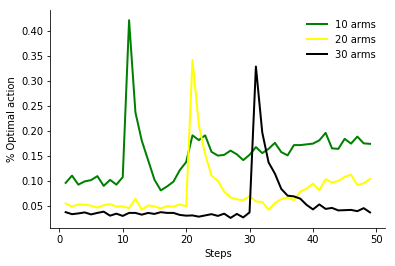

In [104]:
#first 50 steps are shown to magnify oscillations
%matplotlib inline
rewards_data = pd.DataFrame({'x': range(1, 50), 'greedy10': greedy_10[0:49], 
                             'greedy20': greedy_20[0:49], 'greedy30': greedy_30[0:49]})
fig = plt.subplot()
fig.plot( 'x', 'greedy10', data=rewards_data, marker='', color='green', linewidth=2)
fig.plot( 'x', 'greedy20', data=rewards_data, marker='', color='yellow', linewidth=2)
fig.plot( 'x', 'greedy30', data=rewards_data, marker='', color='black', linewidth=2)
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend([r'10 arms', r'20 arms', r'30 arms'], frameon=False)
plt.show()

The size of the jump, on the other hand, greatly depends on the parameters of reward distributions. If the expected value of the best action is much bigger then the expected value of the second best action, then the best action is more likely to be chosen after all actions are sequentially explored. The variance also matters: it is easier to distinguish between different actions when the variance of reward distribution for each action is small then when it is large. See the figure below for illustration. 

In [105]:
#run experiments for later plotting
greedy_1 = [0]*1000
greedy_2 = [0]*1000
greedy_3 = [0]*1000

for x in range(2000):
    new_bandit = Bandit()
    output_1 = new_bandit.run(epsilon = 0, initial = 5, type_al = "alpha")
    output_2 = new_bandit.run(epsilon = 0, initial = 5, type_al = "alpha", variance = 2)
    output_3 = new_bandit.run(epsilon = 0, initial = 5, type_al = "alpha", variance = 3)
    for y in range(1000):
        greedy_1[y] += output_1[0][y]/2000
        greedy_2[y] += output_2[0][y]/2000
        greedy_3[y] += output_3[0][y]/2000
    print(x, end = " ")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

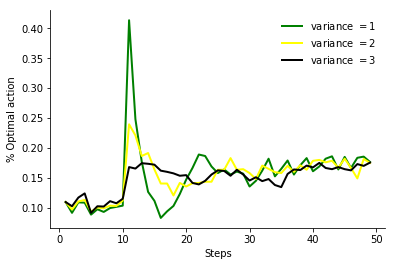

In [106]:
#first 50 steps are shown to magnify oscillations
%matplotlib inline
rewards_data = pd.DataFrame({'x': range(1, 50), 'greedy1': greedy_1[0:49], 
                             'greedy2': greedy_2[0:49], 'greedy3': greedy_3[0:49]})
fig = plt.subplot()
fig.plot( 'x', 'greedy1', data=rewards_data, marker='', color='green', linewidth=2)
fig.plot( 'x', 'greedy2', data=rewards_data, marker='', color='yellow', linewidth=2)
fig.plot( 'x', 'greedy3', data=rewards_data, marker='', color='black', linewidth=2)
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend([r'variance $= 1$', r'variance $= 2$', r'variance $= 3$'], frameon=False)
plt.show()

In [107]:
#replicates figure 2.4
eps = [0]*1000
ucb = [0]*1000

for x in range(2000):
    new_bandit = Bandit()
    output_eps = new_bandit.run(type_al = "average")
    output_ucb = new_bandit.run_ucb(type_al = "average")
    for y in range(1000):
        eps[y] += output_eps[1][y]/2000
        ucb[y] += output_ucb[1][y]/2000

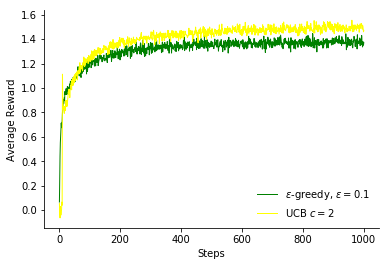

In [108]:
%matplotlib inline
rewards_data = pd.DataFrame({'x': range(1, 1001), 'eps': eps, 
                             'ucb': ucb})
fig = plt.subplot()
fig.plot( 'x', 'eps', data=rewards_data, marker='', color='green', linewidth=1)
fig.plot( 'x', 'ucb', data=rewards_data, marker='', color='yellow', linewidth=1)
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.legend([r'$\epsilon$-greedy, $\epsilon=0.1$', r'UCB $c=2$'], frameon=False)
plt.show()

## Exercise 2.7. <br>
$\mathbb{P}(A_t = a_1) = \frac{e^{H_t(a_1)}}{e^{H_t(a_1)} + e^{H_t(a_2)}}$. Multiplying numerator and denominator by $e^{H_t(a_1)}$ gives $\frac{1}{1 + e^{H_t(a_2) - H_t(a_1)}}$ which corresponds to the logistic distribution function.

In [109]:
#replicates Figure 2.5
#first, define new class Bandit_gradient that inherits from the standard Bandit class
class Bandit_gradient(Bandit):
    

    #run_gradient function
    def run_gradient(self, runs = 1000, alpha = 0.1, variance = 1, type_al = 'baseline', 
                    type_problem = 'stationary', mean_nonstat = 0, variance_nonstat = 0.01):
        #this stores whether optimal action was visited on the n's run
        optimal_actions_pct = [0]*runs
        #this stores rewards for each step
        average_rewards = [0]*runs
        #this stores probabilities for each action
        action_probabilities = [1.00/self.k]*self.k
        #this stores preferences for each action
        action_rewards = [0]*self.k
        #this stores total sum of rewards
        total_rewards = 0
        #define optimal action for stationary problem
        if type_problem == 'stationary':
            optimal = self.q.index(max(self.q))
        #run the simulation
        for run in range(runs):
            #update true action-values and optimal action for non-stationary problem
            if type_problem == 'nonstationary':
                self.q = [i + rd.gauss(mean_nonstat, variance_nonstat) for i in self.q]
                optimal = self.q.index(max(self.q))
            action = np.random.choice(range(self.k), 1, p = action_probabilities) 
            optimal_actions_pct[run] = (action==optimal) 
            reward = rd.gauss(self.q[action[0]], variance)
            #update preferences
            for act in range(self.k):
                if act == action:
                    action_rewards[act] += alpha*(reward - total_rewards)*(1 - action_probabilities[act])
                else:
                    action_rewards[act] -= alpha*(reward - total_rewards)*action_probabilities[act]
            #update probabilities
            action_probabilities = list(map(lambda x: math.exp(x), action_rewards))
            sum_total = sum(action_probabilities)
            action_probabilities = list(map(lambda x: x/sum_total, action_probabilities))
            average_rewards[run] = reward
            if type_al == 'baseline':
                total_rewards = (total_rewards*run + reward)/(run + 1)
        return(optimal_actions_pct, average_rewards)

In [110]:
#figure 2.5
alpha_01_baseline = [0]*1000
alpha_04_baseline = [0]*1000
alpha_01_nobaseline = [0]*1000
alpha_04_nobaseline = [0]*1000

for x in range(2000):
    new_bandit = Bandit_gradient(mean = 4)
    output_01b = new_bandit.run_gradient()
    output_04b = new_bandit.run_gradient(alpha = 0.4)
    output_01nb = new_bandit.run_gradient(type_al = "nobaseline")
    output_04nb = new_bandit.run_gradient(type_al = "nobaseline", alpha = 0.4)    
    for y in range(1000):
        alpha_01_baseline[y] += output_01b[0][y]/2000
        alpha_04_baseline[y] += output_04b[0][y]/2000
        alpha_01_nobaseline[y] += output_01nb[0][y]/2000
        alpha_04_nobaseline[y] += output_04nb[0][y]/2000
    print(x, end= " ")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

1861 1862 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 

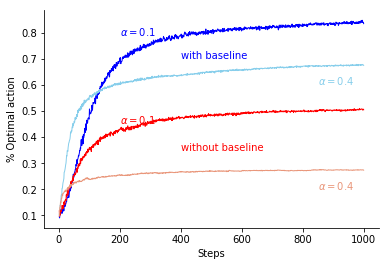

In [111]:
%matplotlib inline
rewards_data = pd.DataFrame({'x': range(1, 1001), 'alpha1': alpha_01_baseline, 
                             'alpha2': alpha_04_baseline, 'alpha3': alpha_01_nobaseline,
                            'alpha4': alpha_04_nobaseline})
fig = plt.subplot()
fig.plot( 'x', 'alpha1', data=rewards_data, marker='', color='blue', linewidth=1)
fig.plot( 'x', 'alpha2', data=rewards_data, marker='', color='skyblue', linewidth=1)
fig.plot( 'x', 'alpha3', data=rewards_data, marker='', color='red', linewidth=1)
fig.plot( 'x', 'alpha4', data=rewards_data, marker='', color='darksalmon', linewidth=1)
fig.text(x = 850, y = 0.2, s = r'$\alpha = 0.4$', color='darksalmon')
fig.text(x = 200, y = 0.45, s = r'$\alpha = 0.1$', color='red')
fig.text(x = 400, y = 0.35, s = r'without baseline', color='red')
fig.text(x = 850, y = 0.6, s = r'$\alpha = 0.4$', color='skyblue')
fig.text(x = 200, y = 0.79, s = r'$\alpha = 0.1$', color='blue')
fig.text(x = 400, y = 0.7, s = r'with baseline', color='blue')
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.show()

## Extensive notes on stochastic gradient ascent (p.29 - p.31) <br>
The content of this cell is essentially the same as in the book, but different exposition format is used. I re-structured different elements of the book's discussion in a Lemma-Theorem format. <br> Everywhere it is assumed that $\pi_t(a) = \frac{e^{H_t(a)}}{\sum_{b}e^{H_t(b)}}$.
### Lemma 1. <br>
Suppose $A$ is a countable action-space. Then $\frac{\partial \pi_t(b)}{\partial H_t(a)} = \pi_t(b)[\mathbb{1}_{b = a} - \pi_t(a)]$. 
### Proof. <br>
$$\frac{\partial \pi_t(b)}{\partial H_t(a)} = \big[(\mathbb{1}_{b=a})\frac{e^{H_t(a)}\sum_{k}e^{H_t(k)} - e^{2 H_t(a)}}{[\sum_{k}e^{H_t(k)}]^2} + (1 - \mathbb{1}_{b=a})\frac{-e^{H_t(b)+H_t(a)}}{[\sum_{k}e^{H_t(k)}]^2}\big] = \mathbb{1}_{b=a}\big[\frac{e^{H_t(a)}\sum_{k}e^{H_t(k)} - e^{2 H_t(a)} + e^{H_t(b)+H_t(a)}}{[\sum_{k}e^{H_t(k)}]^2}\big]- \pi_t(b)\pi_t(a) = \mathbb{1}_{b=a}\pi_t(a) - \pi_t(b)\pi_t(a) = \mathbb{1}_{b=a}\pi_t(b) - \pi_t(b)\pi_t(a) = \pi_t(b)(\mathbb{1}_{b=a} - \pi_t(a))$$ Q.E.D. <br>
### Lemma 2. <br>
Suppose $A$ is a countable action-space. Then $\sum_{b}\frac{\partial \pi_t(b)}{\partial H_t(a)} = 0$.
### Proof. 
$$ \sum_{b}\frac{\partial \pi_t(b)}{\partial H_t(a)} = \sum_{b}\frac{\partial}{\partial H_t(a)}\frac{e^{H_t(b)}}{\sum_{k}e^{H_t(k)}} = \sum_{b}\big[(\mathbb{1}_{b=a})\frac{e^{H_t(a)}\sum_{k}e^{H_t(k)} - e^{2 H_t(a)}}{[\sum_{k}e^{H_t(k)}]^2} + (1 - \mathbb{1}_{b=a})\frac{-e^{H_t(b)+H_t(a)}}{[\sum_{k}e^{H_t(k)}]^2}\big]$$. We can omit the denominator and work with the numerator: $$\sum_{b}\big(\mathbb{1}_{b=a}[e^{H_t(a)}\sum_{k}e^{H_t(k)} - e^{2 H_t(a)}] + (1 - \mathbb{1}_{b=a})[-e^{H_t(b)+H_t(a)}]\big) = e^{H_t(a)}\sum_{k}e^{H_t(k)} - e^{2 H_t(a)} - e^{H_t(a)}\sum_{k \neq a}e^{H_t(k)} = e^{2 H_t(a)} - e^{2 H_t(a)} = 0$$ because all terms for $k \neq a$ cancel out. <br> Q.E.D. <br>
### Theorem
Suppose $A$ is a countable action-space. Then $H_{t+1}(a) = H_t(a) + \alpha*(R_t - \bar{R}_t)(\mathbb{1}_{a=A_t} - \pi_t(a)) \overset{a.s.}{\to} H_t(a) + \alpha\frac{\partial \mathbb{E}R_t}{\partial H_t(a)}$. <br>
### Proof
First, note that $\mathbb{E}[R_t] = \mathbb{E}[\pi_t(b)\mathbb{E}(R_t|b)] = \mathbb{E}[\pi_t(b)q^*(b)] = \sum_{b}\pi_t(b)q^*(b)$ where countability of action-space was used to substitute expectation to the sum. Now, $\frac{\partial \mathbb{E}R_t}{\partial H_t(a)} = \sum_{b}q^*(b)\frac{\partial \pi_t(b)}{\partial H_t(a)} = \sum_{b}(q^*(b) - X_t)(\frac{\partial \pi_t(b)}{\partial H_t(a)})$. The last result follows because $X_t\sum_{b}(\frac{\partial \pi_t(b)}{\partial H_t(a)}) = 0$ by Lemma 2. <br>
We can write: $\sum_{b}(q^*(b) - X_t)(\frac{\partial \pi_t(b)}{\partial H_t(a)}) = \sum_{b}\pi_t(b)(q^*(b) - X_t)(\frac{\partial \pi_t(b)}{\partial H_t(a)})/\pi_t(b) = \mathbb{E}\big[(q^*(b) - X_t)(\frac{\partial \pi_t(b)}{\partial H_t(a)})/\pi_t(b)\big]$. Using Lemma 1, we can re-write this as $\mathbb{E}\big[(q^*(b) - X_t)(\mathbb{1}_{b = a} - \pi_t(a))\big] = \mathbb{E}\big[(q^*(A_t) - X_t)(\mathbb{1}_{A_t = a} - \pi_t(a))\big]$. We can easily substitute $X_t = \bar{R_t}$ since $\bar{R_t}$ is constant for each iteration of the algorithm. The last bit requires proving that $q^*(A_t) = R_t$ is a valid substitution. To see that, note that $$\mathbb{E}\big[R_t(\mathbb{1}_{A_t = a} - \pi_t(a))\big] = \mathbb{E}[q^*(A_t)\pi_t(A_t)\mathbb{1}_{A_t = a}] - \mathbb{E}[q^*(A_t)\pi_t(A_t)\pi_t(a)] = \mathbb{E}[q^*(A_t)(\mathbb{1}_{A_t = a})] - \mathbb{E}[q^*(A_t)\pi_t(a)] = \mathbb{E}[q^*(A_t)(\mathbb{1}_{A_t = a} - \pi_t(a))]$$ where independence and linearity of expectations were used. Therefore, we have $$\frac{\partial \mathbb{E}[R_t]}{\partial H_t(a)} = \mathbb{E}\big[(R_t - \bar{R_t})(\mathbb{1}_{A_t = a} - \pi_t(a))\big]$$. Theorem now trivially follows from SLLN. <br> Q.E.D. 

## Exercise 2.8. <br>
Since the actual states (A or B) are not known in the first scenario, one can use $\epsilon$-greedy algorithm with sample averages for action-value estimates. For such an algorithm, the best estimate will be $\mathbb{E}[R] = \epsilon(0.5(0.5*0.1 + 0.5*0.2) + 0.5(0.5*0.9 + 0.5*0.8)) + (1 - \epsilon)0.5 = \epsilon 0.5 + (1 - \epsilon)0.5 = 0.5$. It is easy to see that, had actual action-values been known, this would have still been the best achievable expected value. <br>
In the second case, I would still use $\epsilon$-greedy algorithm with sample averages for action-value estimates, but I will condition the action-value estimates on the state. In a practical sense, I will store action-value estimates for different states as different action-value estimates. Expected value, therefore, equals $0.5[\epsilon (0.5*0.1 + 0.5*0.2) + (1 - \epsilon)*0.2] + 0.5[\epsilon (0.5*0.9 + 0.5*0.8) + (1 - \epsilon)*0.9] = 0.5[\epsilon + (1 - \epsilon)*1.1] = 0.5[1.1 - 0.1\epsilon]$. As $\epsilon \to 0$, the expected value of the policy goes to $0.55$ which is the best achievable value. 

In [112]:
#replicating Figure 2.6.
par_values = [4/2**i for i in range(10)]

epsilon_greedy = [0]*10
ucb = [0]*10
gradient_bandit = [0]*10
optimistic = [0]*10

for par in range(10):
    epsilon_track = [0]*1000
    ucb_track = [0]*1000
    gradient_bandit_track = [0]*1000
    optimistic_track = [0]*1000
    for x in range(2000):
        bandit = Bandit()
        bandit_gradient = Bandit_gradient()
        output_epsilon = bandit.run(epsilon = par_values[par])
        output_optimistic = bandit.run(epsilon = 0, initial = par_values[par], type_al = "alpha")
        output_ucb = bandit.run_ucb(c = par_values[par])
        output_gradient = bandit_gradient.run_gradient(alpha = par_values[par])    
        for y in range(1000):
            epsilon_track[y] += output_epsilon[1][y]/2000
            ucb_track[y] += output_ucb[1][y]/2000
            gradient_bandit_track[y] += output_gradient[1][y]/2000
            optimistic_track[y] += output_optimistic[1][y]/2000
    epsilon_greedy[par] = sum(epsilon_track)/1000
    ucb[par] = sum(ucb_track)/1000
    gradient_bandit[par] = sum(gradient_bandit_track)/1000
    optimistic[par] = sum(optimistic_track)/1000
    print(par, end= " ")

0 1 2 3 4 5 6 7 8 9 

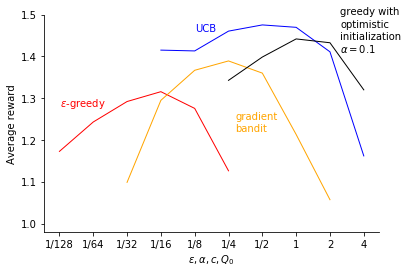

In [113]:
%matplotlib inline
par_plot = [x for x in reversed(range(10))]
fig = plt.subplot()
fig.plot(par_plot[4:], epsilon_greedy[4:], marker='', color='red', linewidth=1)
fig.plot(par_plot[0:7], ucb[0:7], marker='', color='blue', linewidth=1)
fig.plot(par_plot[1:8], gradient_bandit[1:8], marker='', color='orange', linewidth=1)
fig.plot(par_plot[0:5], optimistic[0:5], marker='', color='black', linewidth=1)
fig.text(x = 1/128, y = 1.28, s = r'$\epsilon$-greedy', color='red')
fig.text(x = 5.2, y = 1.25, s = r'gradient', color='orange')
fig.text(x = 5.2, y = 1.22, s = r'bandit', color='orange')
fig.text(x = 4, y = 1.46, s = r'UCB', color='blue')
fig.text(x = 8.3, y = 1.5, s = r'greedy with', color='black')
fig.text(x = 8.3, y = 1.47, s = r'optimistic', color='black')
fig.text(x = 8.3, y = 1.44, s = r'initialization', color='black')
fig.text(x = 8.3, y = 1.41, s = r'$\alpha = 0.1$', color='black')
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
plt.ylim(bottom = 0.98, top = 1.5)
plt.xticks(par_plot, reversed(['1/128', '1/64', '1/32', '1/16', '1/8', '1/4', '1/2', '1', '2', '4']))
plt.xlabel(r'$\epsilon, \alpha, c, Q_0$')
plt.ylabel('Average reward')
plt.show()

## Exercise 2.9. <br>
The code is similar to the one for Figure 2.6 since all functions were designed to handle nonstationary case. Also, instead of using one run of 200000 iterations to compute the measure of performance, I employed the same routine as for the stationary case to get directly comparable performance estimates. As you can see, $\epsilon$-greedy algorithm with constant updates actually performs rather well. 

In [114]:
par_values = [4/2**i for i in range(10)]

epsilon_greedy = [0]*10
ucb = [0]*10
gradient_bandit = [0]*10
optimistic = [0]*10
epsilon_greedy_alpha = [0]*10
for par in range(10):
    epsilon_track = [0]*5000
    ucb_track = [0]*5000
    gradient_bandit_track = [0]*5000
    optimistic_track = [0]*5000
    epsilon_alpha_track = [0]*5000
    for x in range(200):
        all_val = rd.gauss(0,1)
        bandit = Bandit(mean = all_val, variance = 0)
        bandit_gradient = Bandit_gradient(mean = all_val, variance = 0)
        output_epsilon = bandit.run(runs = 5000, epsilon = par_values[par], type_problem = 'nonstationary')
        bandit = Bandit(mean = all_val, variance = 0)
        output_optimistic = bandit.run(runs = 5000, epsilon = 0, initial = par_values[par], 
                                           type_al = 'alpha', type_problem = 'nonstationary')
        bandit = Bandit(mean = all_val, variance = 0)
        output_ucb = bandit.run_ucb(runs = 5000, c = par_values[par], type_problem = 'nonstationary')
        output_gradient = bandit_gradient.run_gradient(runs = 5000, alpha = par_values[par],
                                                           type_problem = 'nonstationary')
        bandit = Bandit(mean = all_val, variance = 0)
        output_epsilon_alpha = bandit.run(runs = 5000, epsilon = par_values[par], 
                                        type_problem = 'nonstationary', type_al = 'alpha')
        for y in range(5000):
            epsilon_track[y] += output_epsilon[1][y]/200
            ucb_track[y] += output_ucb[1][y]/200
            gradient_bandit_track[y] += output_gradient[1][y]/200
            optimistic_track[y] += output_optimistic[1][y]/200
            epsilon_alpha_track[y] += output_epsilon_alpha[1][y]/200
    epsilon_greedy[par] = sum(epsilon_track)/5000
    ucb[par] = sum(ucb_track)/5000
    gradient_bandit[par] = sum(gradient_bandit_track)/5000
    optimistic[par] = sum(optimistic_track)/5000
    epsilon_greedy_alpha[par] = sum(epsilon_alpha_track)/5000
    print(par, end= " ")

0 1 2 3 4 5 6 7 8 9 

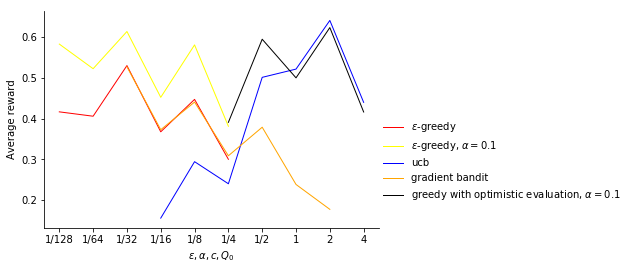

In [115]:
%matplotlib inline
par_plot = [x for x in reversed(range(10))]
fig = plt.subplot()
fig.plot(par_plot[4:], epsilon_greedy[4:], marker='', color='red', linewidth=1)
fig.plot(par_plot[4:], epsilon_greedy_alpha[4:], marker='', color='yellow', linewidth=1)
fig.plot(par_plot[0:7], ucb[0:7], marker='', color='blue', linewidth=1)
fig.plot(par_plot[1:8], gradient_bandit[1:8], marker='', color='orange', linewidth=1)
fig.plot(par_plot[0:5], optimistic[0:5], marker='', color='black', linewidth=1)
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
plt.xticks(par_plot, reversed(['1/128', '1/64', '1/32', '1/16', '1/8', '1/4', '1/2', '1', '2', '4']))
plt.xlabel(r'$\epsilon, \alpha, c, Q_0$')
plt.ylabel('Average reward')
plt.legend([r'$\epsilon$-greedy', r'$\epsilon$-greedy, $\alpha=0.1$', r'ucb', r'gradient bandit',
            r'greedy with optimistic evaluation, $\alpha=0.1$'], loc = (1, 0.1), frameon=False)
plt.show()